# **My electrophoresis sense is tingling. 🕷️ Predicting maintenance.**

---
## **Overview**
* Dataset source : [E-coating ultrafiltration maintenance](https://www.kaggle.com/boyangs444/process-data-for-predictive-maintenance) sensors dataset for a 20 year old electrophoresis plant
* Dataset type : multivariate time series
* Goal : predict the flow rate `FM1` using sensor readings


⚠️ **NOTE** : This is not an end to end project. It is an experiment to use neural networks to predict time series data.


## **The problem**
In manufacturing plants machinery will require maintenance over time. The problem is that if there is no maintenance then there will be failures, potential injuries and costs associated for repairs.

The other downside is staffing. If you do not have predictive maintenance inplace and it is important to fix problems ASAP then you will require skilled staff available almost 24/7, that in inefficient use of budget and people's time. With predictive maintenance you may not be able to be 100% accurate but even if it's 80% accurate I see that as a win given the efficiency gains.

## **Setup**
`fast.ai` has a number of unofficial extensions that people have developed. I'm using `tsai` [repo here](https://github.com/timeseriesAI/tsai) which focuses on time series. It was created by *Ignacio Oguiza*.

Some examples of uses/functions are:
* Classification, regression and forecasting
* Prepping time series data appropriately
* Converting time series datasets into images

Along with this library there are some other libraries used for plotting and data processing.


In [ ]:
!pip install tsai --upgrade # Colab was used hence the install

In [ ]:
from tsai.all import * # tsai
import pandas as pd # Data processing
import plotly.express as px # Plots

/usr/local/lib/python3.6/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning:

The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.



## **Data**
The data is from a electrophoresis painting plant that is 20 years old. The dataset if for a 14 day period where sensors are used to log the following inputs:
* **Pressure** - `PE1`, `PE2`, `PE3`, `PE4`
* **Temperature** - `TP1`, `TP2`
* **Flow** - `FM1` (target)

The data has already been normalised hence very little preprocessing is required.

In [ ]:
iot = pd.read_csv("iiot_30min_norm.csv") # Read in data

iot["TIME"] = pd.to_datetime(iot["TIME"], infer_datetime_format = True) # Make sure TIME is in datetime format

In [ ]:
iot.head()

,TIME,FM1,PE1,PE2,PE3,PE4,TP1,TP2,EPOCH
0,2020-07-05 21:00:00+00:00,0.291841,0.944212,0.969845,0.909817,0.752879,0.128703,0.729592,1593982800
1,2020-07-05 21:30:00+00:00,0.290384,0.947971,0.971459,0.913576,0.753741,0.117572,0.723905,1593984600
2,2020-07-05 22:00:00+00:00,0.279458,0.944138,0.968994,0.912516,0.753187,0.111242,0.720671,1593986400
3,2020-07-05 22:30:00+00:00,0.288927,0.950337,0.976253,0.915991,0.756699,0.102464,0.716186,1593988200
4,2020-07-05 23:00:00+00:00,0.299610,0.950226,0.975747,0.916188,0.756563,0.093201,0.711454,1593990000


## **Plots**


Before plotting and modelling I need to see if all data points have the same duration between them (they do).

In [ ]:
time_diff = iot["TIME"] - iot["TIME"].shift() # Take the current row and subtract the adjacent row
time_diff.unique() # All dates are 30 mins apart, NaT is the row of data that doesn't have an adjacent row

array([        'NaT', 1800000000000], dtype='timedelta64[ns]')

The data can be plotted as such.

In [ ]:
fig = px.line(iot, x = "TIME", y = "FM1")
for col in ["PE2", "PE1",	"PE2", "PE3", "PE4", "TP1", "TP2"]:
  fig.add_scatter(x = iot['TIME'], y = iot[col], mode = 'lines', name = col)
fig.show()

## **Setting up TSAI/the data**
The way the data is being split is by using `SlidingWindow`. The way this works is by specifying
* `window_len` - the length of a sequence (in this case 6 is denoting 3 hours as each data point is 30 minutes)
* `get_x` - the columns to use (indicies of columns used)
* `get_y` - the target column (name used)
* `stride` - how much to move the window by each time
* `horizon` - how far from the last data point to predict (1 is saying to predict the next y after the 3 hour chunk)
* `ascending` - sort by ascending order
* `seq_first` - used as it's a dataframe


Visually it is like this.

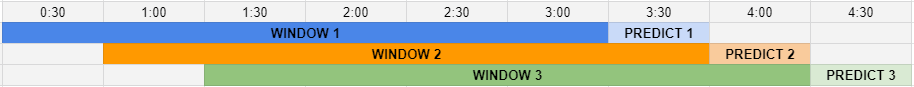

In [ ]:
X, y = SlidingWindow(window_len = 6, get_x = [2, 3, 4, 5, 6], get_y = "FM1", stride = 1, horizon = 1, sort_by = ["TIME"], ascending = True, seq_first = True)(iot) # Split into windows
X.head(), y.head()

(array([[[0.9442119 , 0.94797057, 0.9441379 , 0.9503366 , 0.9502257 ,
          0.94583863],
         [0.9698446 , 0.97145903, 0.9689942 , 0.9762528 , 0.97574747,
          0.97476155],
         [0.9098173 , 0.91357595, 0.91251606, 0.9159912 , 0.9161884 ,
          0.91490686],
         [0.75287855, 0.75374126, 0.7531867 , 0.7566987 , 0.75656325,
          0.7560704 ],
         [0.12870277, 0.11757235, 0.11124238, 0.10246424, 0.0932012 ,
          0.09090909]],
 
        [[0.94797057, 0.9441379 , 0.9503366 , 0.9502257 , 0.94583863,
          0.9464547 ],
         [0.97145903, 0.9689942 , 0.9762528 , 0.97574747, 0.97476155,
          0.97091264],
         [0.91357595, 0.91251606, 0.9159912 , 0.9161884 , 0.91490686,
          0.9119636 ],
         [0.75374126, 0.7531867 , 0.7566987 , 0.75656325, 0.7560704 ,
          0.7520776 ],
         [0.11757235, 0.11124238, 0.10246424, 0.0932012 , 0.09090909,
          0.091888  ]],
 
        [[0.9441379 , 0.9503366 , 0.9502257 , 0.94583863, 0.9464

With the data in "windows" it can now be split into training and validation datasets. It is important to not shuffle the data as the aim is to forecast the future. If the data is shuffled data leakage could occur.

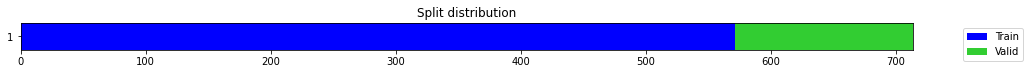

In [ ]:
splits = get_splits(y, valid_size = .2, random_state = 23, shuffle = False) # Split

After splitting the data, dataloaders can now be created. `TSForecasting` must be declared given the task is to forecast `FM1`. Interestingly `shuffle_train` is set to `True`. The reason for this is because it means the training data is shuffled but the validation data isn't shuffled. There isn't any data leakage when the training data is shuffled. 

In [ ]:
tfms  = [None, [TSForecasting()]] 
dls = get_ts_dls(X, y, tfms = tfms, splits = splits, bs = 4, shuffle_train = True, device = default_device(use_cuda = True), inplace = True)

A quick check can be done to see if it is a single input (what is required) before creating a model.

In [ ]:
dls.c

1

And a few examples from a batch can be seen.

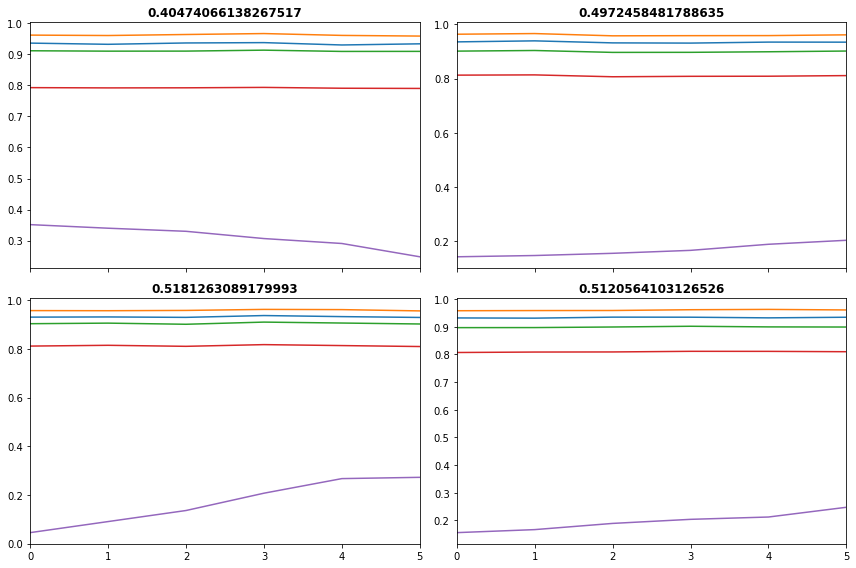

In [ ]:
dls.show_batch()

## **First model**

In [ ]:
learn = ts_learner(dls, LSTM_FCN, metrics = mae, device = default_device(use_cuda = True), shuffle = False)

SuggestedLRs(lr_min=0.00043651582673192023, lr_steep=1.9054607491852948e-06)

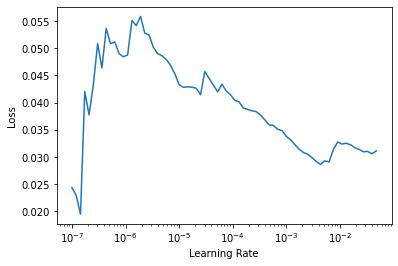

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,mae,time
0,0.013577,0.010094,0.071636,00:01


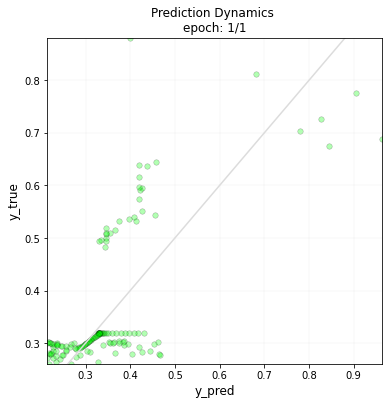

,train_loss,valid_loss,mae
0,0.013577,0.010094,0.071636


epoch,train_loss,valid_loss,mae,time
0,0.009961,0.007849,0.067143,00:01
1,0.009172,0.006535,0.060389,00:01
2,0.007951,0.005946,0.052377,00:01
3,0.008788,0.006055,0.049941,00:01
4,0.008709,0.005208,0.054694,00:01
5,0.008746,0.004523,0.046472,00:01
6,0.007928,0.006773,0.067158,00:01
7,0.008255,0.004697,0.053397,00:01
8,0.008915,0.004009,0.047275,00:01
9,0.007717,0.005803,0.065389,00:01


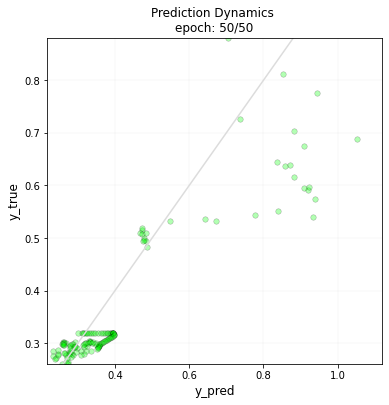

,train_loss,valid_loss,mae
49,0.00367,0.010593,0.063751


In [ ]:
learn.fine_tune(50, 1e-4, cbs = [PredictionDynamics], wd = 0.01)

## **Comparing models**

`InceptionTime` is a model architecture that is commonly used for time series given it's high performance. The architecture has been implemented in `tsai` and is the preferred method for this task. 

However with experimenting with different hyperparameters the results can vary significantly. However I do not want to spend time guessing hyperparameters so a mini grid search loop has been created to find potentially optimal values (bayesian optimisation could also be used but I want a more exhaustive search).

### Create list of architectures with varying hyperparameters

In [ ]:
archs = []

for y in range(10, 14):
  for x in range(1, 10):
    archs.append((InceptionTime, {"nf" : y,
                                  "ks" : x * 5}))

archs

[(tsai.models.InceptionTime.InceptionTime, {'ks': 5, 'nf': 10}),
 (tsai.models.InceptionTime.InceptionTime, {'ks': 10, 'nf': 10}),
 (tsai.models.InceptionTime.InceptionTime, {'ks': 15, 'nf': 10}),
 (tsai.models.InceptionTime.InceptionTime, {'ks': 20, 'nf': 10}),
 (tsai.models.InceptionTime.InceptionTime, {'ks': 25, 'nf': 10}),
 (tsai.models.InceptionTime.InceptionTime, {'ks': 30, 'nf': 10}),
 (tsai.models.InceptionTime.InceptionTime, {'ks': 35, 'nf': 10}),
 (tsai.models.InceptionTime.InceptionTime, {'ks': 40, 'nf': 10}),
 (tsai.models.InceptionTime.InceptionTime, {'ks': 45, 'nf': 10}),
 (tsai.models.InceptionTime.InceptionTime, {'ks': 5, 'nf': 11}),
 (tsai.models.InceptionTime.InceptionTime, {'ks': 10, 'nf': 11}),
 (tsai.models.InceptionTime.InceptionTime, {'ks': 15, 'nf': 11}),
 (tsai.models.InceptionTime.InceptionTime, {'ks': 20, 'nf': 11}),
 (tsai.models.InceptionTime.InceptionTime, {'ks': 25, 'nf': 11}),
 (tsai.models.InceptionTime.InceptionTime, {'ks': 30, 'nf': 11}),
 (tsai.model

## Run the grid search

In [ ]:
results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'mae', 'time']) # Create dataframe for results

for i, (arch, k) in enumerate(archs):
    
    # Initialise the model
    model = create_model(arch, dls = dls, **k)
    print(model.__class__.__name__)
    
    # Create the fastai/tsai learner
    learn = Learner(dls, model,  metrics = mae)

    # Initialise the start time
    start = time.time()

    # Fit for 
    # - 50 epochs
    # - 1e-4 learning rate
    # - Print the actual vs predicted graph using PredictionDynamics callback after each epoch
    learn.fit_one_cycle(50, 1e-4, cbs = PredictionDynamics)

    # Calculate and store time taken
    elapsed = time.time() - start
    
    # Take the results and store them in the results dataframe
    vals = learn.recorder.values[-1]
    results.loc[i] = [arch.__name__, k, total_params(model)[0], vals[0], vals[1], vals[2], int(elapsed)]
    
    # Sort the results by mae and display the current results
    results.sort_values(by = 'mae', ascending = False, ignore_index = True, inplace = True)
    clear_output()
    display(results)

,arch,hyperparams,total params,train loss,valid loss,mae,time
0,InceptionTime,"{'nf': 13, 'ks': 25}",49609,0.004375,0.136942,0.182611,177
1,InceptionTime,"{'nf': 12, 'ks': 5}",12985,0.005319,0.106455,0.151807,176
2,InceptionTime,"{'nf': 12, 'ks': 20}",35449,0.005307,0.091891,0.143020,178
3,InceptionTime,"{'nf': 10, 'ks': 5}",9181,0.006024,0.155773,0.137044,168
4,InceptionTime,"{'nf': 11, 'ks': 5}",11001,0.004845,0.145633,0.134531,169
5,InceptionTime,"{'nf': 10, 'ks': 30}",35581,0.004536,0.137350,0.129786,171
6,InceptionTime,"{'nf': 10, 'ks': 10}",13981,0.004926,0.129628,0.122069,168
7,InceptionTime,"{'nf': 12, 'ks': 10}",19897,0.004708,0.120933,0.118356,177
8,InceptionTime,"{'nf': 11, 'ks': 35}",48753,0.004578,0.070303,0.114459,174
9,InceptionTime,"{'nf': 12, 'ks': 25}",42361,0.004138,0.096733,0.113530,178
